In [ ]:
!pip install tslearn
!pip install fuzzy-c-means

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tslearn.metrics import lcss, dtw
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
import sklearn
import math

In [ ]:
def generate_random_colors(number_of_colors):
    """
    Generates random colors as hex codes.

    Parameters:
    number_of_colors (int): the number of colors to generate
    
    Returns:
    list: a list of hex color codes
    """
    colors = np.random.randint(256, size=(number_of_colors, 3))
    random_colors = ["#{:02x}{:02x}{:02x}".format(r, g, b) for r, g, b in colors]
    return random_colors

In [ ]:
def create_remastered_df(df):
    """
    Gets the trajectory dataframe, groups the data by trackId and reformats the dataframe
    Parameters:
    ffdstring): trajectories df
    
    Returns:
    pandas dataframe: containing 'trackId' and 'trajectory' columns
    """
    trajec_dict = {
    'trackId': [],
    'trajectory': [],
    }
    for trackid, group_df in df.groupby("trackId"):
        group_df = group_df.sort_values(by='trackLifetime')
        trajec_dict["trackId"].append(trackid)
        trajec_dict["trajectory"].append(list(zip(group_df['xCenter'],group_df['yCenter'])))
    remastered_df = pd.DataFrame(trajec_dict)
    return remastered_df

In [ ]:
def create_distance_metrix(df, metric):
  """
    This function takes a dataframe and a distance metric and returns a distance metric matrix.
    
    Parameters:
        - df (pd.DataFrame): The input dataframe, with a column 'trajectory' that contains the trajectory data.
        - metric (str): The distance metric to use, one of 'lcss' or 'dtw'
    
    Returns:
        - np.ndarray: A distance metric matrix with shape (n, n) where n is the number of rows in df.
    """
  distance_metrics = {'lcss': lcss, 'dtw': dtw}
  distance_metric = np.zeros((len(df), len(df)))
  for i in range(len(df)):
    i_array = np.array(df.iloc[i]['trajectory'])
    for j in range(len(df)):
      j_array = np.array(df.iloc[j]['trajectory'])
      distance_metric[i][j] = distance_metrics[metric](i_array, j_array)
      distance_metric[j][i] = distance_metric[i][j]
  return distance_metric

In [ ]:
def measure_clustering_performance(X, labels, metric=None):
    """
    This function takes a dataset, cluster labels and a metric, and returns the performance of clustering.
    
    Parameters:
        - X (np.ndarray or pd.DataFrame): The dataset to be clustered, with shape (n_samples, n_features).
        - labels (np.ndarray): The cluster labels, with shape (n_samples,).
        - metric (str): The performance metric to use, one of 'silhouette', 'calinski_harabasz' or 'davies_bouldin'.
    
    Returns:
        - float or dict: The performance of clustering, as measured by the specified metric or all metrics if metric is None
    """
    metrics = {'silhouette': silhouette_score, 'calinski_harabasz': calinski_harabasz_score, 'davies_bouldin': davies_bouldin_score}
    
    if metric is None:
        scores = {}
        for metric_name, metric_func in metrics.items():
            scores[metric_name] = round(metric_func(X, labels), 2)
        return scores
    elif metric not in metrics:
        raise ValueError(f"Invalid metric: {metric}. Choose one of {', '.join(metrics.keys())}")
    else:
        return metrics[metric](X, labels)

In [ ]:
def select_random_df(df, size_of_the_selected_df):
    """
    This function takes a dataframe and a size_of_the_selected_df 
    and returns a new dataframe consisting of a random sample of the rows of the input dataframe.
    
    Parameters:
        - df (pd.DataFrame): The input dataframe
        - size_of_the_selected_df (int): The number of rows in the output dataframe. Must be less than or equal to the number of rows in df.
    
    Returns:
        - pd.DataFrame: A new dataframe consisting of a random sample of the rows of the input dataframe.
    """
    if size_of_the_selected_df > len(df):
        raise ValueError("size_of_the_selected_df must be less than or equal to the number of rows in df")
    selected_df = df.sample(n=size_of_the_selected_df, random_state=1)
    return selected_df

In [ ]:
# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# List of file names
files = ["drive/MyDrive/ThesisData/data/{}_tracks.csv".format(f"{i:02}") for i in range(2,24)]

# Iterate over the file names
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # increase the value of the track id by the number of unique trackid in the combined_df 
    if not combined_df.empty:
        unique_track_id_count = combined_df['trackId'].nunique()
        df['trackId'] = df['trackId'] + unique_track_id_count
    
    # Append the data from the current DataFrame to the combined DataFrame
    combined_df = combined_df.append(df, ignore_index=True)

# Print the combined DataFrame
combined_df

recordingId  trackId  frame  trackLifetime  xCenter  yCenter  \
0                  2        0  11127              0  92.7070 -82.3122   
1                  2        0  11128              1  92.7507 -82.2938   
2                  2        0  11129              2  92.7945 -82.2754   
3                  2        0  11130              3  92.8390 -82.2566   
4                  2        0  11131              4  92.8844 -82.2372   
...              ...      ...    ...            ...      ...      ...   
5035781           23    13128  23712            140  71.5383 -63.3552   
5035782           23    13128  23713            141  71.7839 -63.4703   
5035783           23    13128  23714            142  72.0310 -63.5823   
5035784           23    13128  23715            143  72.2840 -63.6944   
5035785           23    13128  23716            144  72.5366 -63.8030   

          heading   width  length  xVelocity  yVelocity  xAcceleration  \
0         23.8856  0.6988  0.8824     1.0883     0.4566         0.1823   
1         23.9028  0.6988  0.8824     1.0969     0.4670         0.1837   
2         23.9228  0.6988  0.8824     1.1057     0.4777         0.1839   
3         23.9454  0.6988  0.8824     1.1145     0.4887         0.1831   
4         23.9703  0.6988  0.8824     1.1230     0.4999         0.1812   
...           ...     ...     ...        ...        ...            ...   
5035781  332.0436  2.1015  4.5571     6.1692    -2.9253         0.7953   
5035782  332.5928  2.1015  4.5571     6.2020    -2.8572         0.7980   
5035783  333.1645  2.1015  4.5571     6.2356    -2.7895         0.7993   
5035784  333.7808  2.1015  4.5571     6.2681    -2.7212         0.7996   
5035785  334.3983  2.1015  4.5571     6.3001    -2.6524         0.7996   

         yAcceleration  lonVelocity  latVelocity  lonAcceleration  \
0               0.2408       1.1800       0.0232           0.2642   
1               0.2443       1.1921       0.0175           0.2669   
2               0.2472       1.2044       0.0117           0.2684   
3               0.2493       1.2169       0.0057           0.2685   
4               0.2504       1.2292      -0.0006           0.2673   
...                ...          ...          ...              ...   
5035781         1.7231       6.8206      -0.3082          -0.1053   
5035782         1.7210       6.8211      -0.3184          -0.0838   
5035783         1.7200       6.8234      -0.3258          -0.0632   
5035784         1.7198       6.8254      -0.3281          -0.0425   
5035785         1.7198       6.8277      -0.3304          -0.0220   

         latAcceleration  
0                -0.1464  
1                -0.1490  
2                -0.1514  
3                -0.1535  
4                -0.1552  
...                  ...  
5035781          -1.8949  
5035782          -1.8952  
5035783          -1.8956  
5035784          -1.8961  
5035785          -1.8964  

[5035786 rows x 17 columns]

In [ ]:
remastered_df = create_remastered_df(df=combined_df)

In [ ]:
remastered_df['trajectory_length'] = remastered_df.apply(lambda row: len(row['trajectory']), axis=1)

In [ ]:
remastered_df

trackId                                         trajectory  \
0            0  [(92.707, -82.3122), (92.7507, -82.2938), (92....   
1            1  [(75.9735, -76.7598), (76.0249, -76.7053), (76...   
2            2  [(84.3821, -69.4747), (84.5787, -69.3829), (84...   
3            3  [(95.105, -63.5575), (95.4032, -63.4384), (95....   
4            4  [(57.4754, -51.4526), (57.6063, -51.6123), (57...   
...        ...                                                ...   
13124    13124  [(120.2573, -53.5251), (120.1821, -53.4952), (...   
13125    13125  [(115.9183, -51.499), (115.7571, -51.4388), (1...   
13126    13126  [(42.5216, -42.5007), (42.689, -42.5538), (42....   
13127    13127  [(120.2574, -53.3208), (120.0791, -53.2526), (...   
13128    13128  [(42.2702, -42.5472), (42.4977, -42.6197), (42...   

       trajectory_length  
0                   1312  
1                    354  
2                    390  
3                    112  
4                    265  
...                  ...  
13124                290  
13125                214  
13126                198  
13127                146  
13128                145  

[13129 rows x 3 columns]

In [ ]:
mask = remastered_df['trajectory_length'] <= 2 * remastered_df['trajectory_length'].mean()
remastered_df = remastered_df[mask]
remastered_df

trackId                                         trajectory  \
1            1  [(75.9735, -76.7598), (76.0249, -76.7053), (76...   
2            2  [(84.3821, -69.4747), (84.5787, -69.3829), (84...   
3            3  [(95.105, -63.5575), (95.4032, -63.4384), (95....   
4            4  [(57.4754, -51.4526), (57.6063, -51.6123), (57...   
5            5  [(32.3329, -39.391), (32.6776, -39.4929), (33....   
...        ...                                                ...   
13124    13124  [(120.2573, -53.5251), (120.1821, -53.4952), (...   
13125    13125  [(115.9183, -51.499), (115.7571, -51.4388), (1...   
13126    13126  [(42.5216, -42.5007), (42.689, -42.5538), (42....   
13127    13127  [(120.2574, -53.3208), (120.0791, -53.2526), (...   
13128    13128  [(42.2702, -42.5472), (42.4977, -42.6197), (42...   

       trajectory_length  
1                    354  
2                    390  
3                    112  
4                    265  
5                    408  
...                  ...  
13124                290  
13125                214  
13126                198  
13127                146  
13128                145  

[12738 rows x 3 columns]

In [ ]:
selected_df = select_random_df(df=remastered_df, size_of_the_selected_df=90)
selected_df

trackId                                         trajectory  \
13092    13092  [(94.5438, -7.8921), (94.4281, -8.1211), (94.3...   
11737    11737  [(43.4737, -42.3048), (43.5791, -42.3507), (43...   
1509      1509  [(138.9318, -59.832), (138.6394, -59.7165), (1...   
11822    11822  [(94.7367, -7.3518), (94.6408, -7.5626), (94.5...   
157        157  [(142.03, -57.1978), (141.7436, -57.083), (141...   
...        ...                                                ...   
655        655  [(75.2407, -75.3869), (75.2704, -75.3495), (75...   
7983      7983  [(93.605, -7.5993), (93.5386, -7.7198), (93.47...   
2588      2588  [(16.1759, -37.3808), (16.6371, -37.5403), (17...   
1624      1624  [(139.8958, -60.5916), (139.6032, -60.4839), (...   
7818      7818  [(40.9622, -41.7922), (41.1618, -41.8657), (41...   

       trajectory_length  
13092                479  
11737                358  
1509                 419  
11822                243  
157                  181  
...                  ...  
655                  403  
7983                 297  
2588                 121  
1624                 481  
7818                 417  

[90 rows x 3 columns]

In [ ]:
import plotly.graph_objects as go

# Plot the results using plotly
fig = go.Figure()
for metric in metrics:
    fig.add_trace(go.Scatter(x=sizes, y=results[metric], mode='lines+markers', name=metric))
fig.update_layout(
    xaxis_title='Number of Trajectories',
    yaxis_title='Computation time (s)',
    legend=dict(x=0.1, y=1, traceorder='normal', font=dict(family='sans-serif', size=12, color='#000'))
)
fig.show()

In [ ]:
lcss_distance_matrix = create_distance_metrix(df=selected_df, metric="lcss")
lcss_distance_matrix

array([[1.        , 0.03072626, 0.32696897, ..., 0.        , 0.05427975,
        0.0263789 ],
       [0.03072626, 1.        , 0.03072626, ..., 0.        , 0.        ,
        0.91340782],
       [0.32696897, 0.03072626, 1.        , ..., 0.        , 0.28162291,
        0.0263789 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05427975, 0.        , 0.28162291, ..., 0.        , 1.        ,
        0.        ],
       [0.0263789 , 0.91340782, 0.0263789 , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
dtw_distance_matrix = create_distance_metrix(df=selected_df, metric="dtw")
dtw_distance_matrix

array([[   0.        ,  901.66908592,  595.05213087, ...,  979.87146934,
         800.90665427,  955.19763087],
       [ 901.66908592,    0.        , 1065.88605296, ...,  543.29118515,
        1335.93700627,   15.97095076],
       [ 595.05213087, 1065.88605296,    0.        , ..., 1139.40704963,
         353.01589802, 1102.14753371],
       ...,
       [ 979.87146934,  543.29118515, 1139.40704963, ...,    0.        ,
        1310.10074965,  654.63333408],
       [ 800.90665427, 1335.93700627,  353.01589802, ..., 1310.10074965,
           0.        , 1370.67448537],
       [ 955.19763087,   15.97095076, 1102.14753371, ...,  654.63333408,
        1370.67448537,    0.        ]])

In [ ]:
km_lcss = TimeSeriesKMeans(n_clusters=16, max_iter=20, random_state=0)
k_means_clusters_lcss = km_lcss.fit_predict(X=lcss_distance_matrix)

In [ ]:
silhouette_vals = silhouette_samples(lcss_distance_matrix, k_means_clusters_lcss)

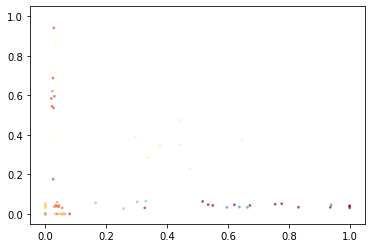

In [ ]:
# Plot the results
colors = plt.cm.Spectral(k_means_clusters_lcss.astype(float) / 16)
plt.scatter(lcss_distance_matrix[:, 0], lcss_distance_matrix[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)
plt.show()

In [ ]:
km_lcss = TimeSeriesKMeans(n_clusters=16, max_iter=20, random_state=0)
km_dtw = TimeSeriesKMeans(n_clusters=16, max_iter=20, random_state=0)
km_lcss_2 = TimeSeriesKMeans(n_clusters=12, max_iter=20, random_state=0)
km_dtw_2 = TimeSeriesKMeans(n_clusters=12, max_iter=20, random_state=0)


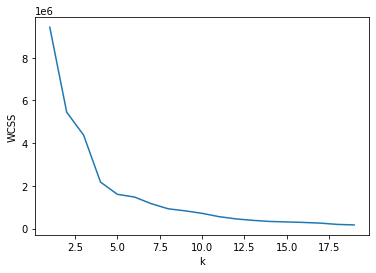

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create an empty list to store the within-cluster sum of squares (WCSS) for each k
wcss = []

# try k values from 1 to 19
for k in range(1, 20):
    # fit the k-means model on the data
    kmeans = TimeSeriesKMeans(n_clusters=k, max_iter=10, random_state=0)
    kmeans.fit(dtw_distance_matrix)
    # append the WCSS for this k to the list
    wcss.append(kmeans.inertia_)

# plot the WCSS for each k
plt.plot(range(1, 20), wcss)
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

In [ ]:
k_means_clusters_lcss = km_lcss.fit_predict(X=lcss_distance_matrix)
k_means_clusters_dtw = km_dtw.fit_predict(X=dtw_distance_matrix)
k_means_clusters_lcss_2 = km_lcss_2.fit_predict(X=lcss_distance_matrix)
k_means_clusters_dtw_2 = km_dtw_2.fit_predict(X=dtw_distance_matrix)

In [ ]:
measure_clustering_performance(X=lcss_distance_matrix, labels=k_means_clusters_lcss)

{'silhouette': 0.41, 'calinski_harabasz': 48.71, 'davies_bouldin': 0.88}

In [ ]:
measure_clustering_performance(X=dtw_distance_matrix, labels=k_means_clusters_dtw)

{'silhouette': 0.58, 'calinski_harabasz': 133.39, 'davies_bouldin': 0.6}

In [ ]:
measure_clustering_performance(X=dtw_distance_matrix, labels=k_means_clusters_dtw_2)

{'silhouette': 0.63, 'calinski_harabasz': 137.74, 'davies_bouldin': 0.51}

In [ ]:
measure_clustering_performance(X=lcss_distance_matrix, labels=k_means_clusters_lcss_2)

{'silhouette': 0.40536886042052084,
 'calinski_harabasz': 49.020431862409694,
 'davies_bouldin': 1.0510581431283834}

In [ ]:
km_color_dict = {0:"red",
                 1:"#05513C",
                 2:"blue",
                 3:"black",
                 4:"purple",
                 5:"orange",
                 6:"cyan",
                 7:"grey",
                 8:"pink",
                 9:"brown",
                 10:"yellow",
                 11:"#d2b486",
                 12:"#d2691e"}

In [ ]:
selected_df['k_means_clusters_lcss'] = k_means_clusters_lcss
selected_df['k_means_clusters_dtw'] = k_means_clusters_dtw_2
selected_df['k_means_lcss_color'] = selected_df.apply(lambda row: km_color_dict[row['k_means_clusters_lcss']], axis=1)
selected_df['k_means_dtw_color'] = selected_df.apply(lambda row: km_color_dict[row['k_means_clusters_dtw']], axis=1)

In [ ]:
selected_df

trackId                                         trajectory  \
13092    13092  [(94.5438, -7.8921), (94.4281, -8.1211), (94.3...   
11737    11737  [(43.4737, -42.3048), (43.5791, -42.3507), (43...   
1509      1509  [(138.9318, -59.832), (138.6394, -59.7165), (1...   
11822    11822  [(94.7367, -7.3518), (94.6408, -7.5626), (94.5...   
157        157  [(142.03, -57.1978), (141.7436, -57.083), (141...   
...        ...                                                ...   
655        655  [(75.2407, -75.3869), (75.2704, -75.3495), (75...   
7983      7983  [(93.605, -7.5993), (93.5386, -7.7198), (93.47...   
2588      2588  [(16.1759, -37.3808), (16.6371, -37.5403), (17...   
1624      1624  [(139.8958, -60.5916), (139.6032, -60.4839), (...   
7818      7818  [(40.9622, -41.7922), (41.1618, -41.8657), (41...   

       trajectory_length  k_means_clusters_lcss  k_means_clusters_dtw  \
13092                479                      0                     0   
11737                358                      8                     1   
1509                 419                      1                     4   
11822                243                     14                     0   
157                  181                     13                     7   
...                  ...                    ...                   ...   
655                  403                      3                     2   
7983                 297                      0                     0   
2588                 121                     10                     5   
1624                 481                      5                    10   
7818                 417                      8                     1   

      k_means_lcss_color k_means_dtw_color  
13092            #e7c154           #e7c154  
11737            #392a6a           #6d0b1e  
1509             #6d0b1e           #6222a6  
11822            #bdfcde           #e7c154  
157              #3fcf35           #38695d  
...                  ...               ...  
655              #34fd6e           #830301  
7983             #e7c154           #e7c154  
2588             #5a1e75           #5491e2  
1624             #5491e2           #5a1e75  
7818             #392a6a           #6d0b1e  

[90 rows x 7 columns]

In [ ]:
kmeans_lcss_fig = go.Figure()
for index, row in selected_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    kmeans_lcss_fig.add_trace(go.Scatter(x=a, y=b, line=dict(color=row['k_means_lcss_color'])))
kmeans_lcss_fig.update_layout(template="plotly_white")
kmeans_lcss_fig.show()

In [ ]:
import itertools
number_of_rows = [1, 2, 3, 4]
plot_indexes = list(itertools.product(number_of_rows, repeat=2))

In [ ]:
from plotly.subplots import make_subplots
sub_fig = make_subplots(rows=4, cols=4)
for i, j in zip(range(16), plot_indexes):
  cluster_df = selected_df[selected_df['k_means_clusters_lcss']==i]
  for index, row in cluster_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    sub_fig.append_trace(go.Scatter(x=a, y=b, line=dict(color=row['k_means_lcss_color'])), row=j[0], col=j[1])
sub_fig.update_layout(template="plotly_white",  title_text="Individual Clusters with K means using LCSS")
sub_fig.show()

In [ ]:
kmeans_dtw_fig = go.Figure()
for index, row in selected_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    kmeans_dtw_fig.add_trace(go.Scatter(x=a, y=b, line=dict(color=row['k_means_dtw_color'])))
kmeans_dtw_fig.update_layout(template="plotly_white")
kmeans_dtw_fig.show()

In [ ]:
number_of_rows = [1, 2, 3, 4]
plot_indexes = list(itertools.product(number_of_rows, repeat=2))
plot_indexes

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [ ]:

from plotly.subplots import make_subplots
sub_fig = make_subplots(rows=4, cols=4)
for i, j in zip(range(16), plot_indexes):
  cluster_df = selected_df[selected_df['k_means_clusters_dtw']==i]
  for index, row in cluster_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    sub_fig.append_trace(go.Scatter(x=a, y=b, line=dict(color=row['k_means_dtw_color'])), row=j[0], col=j[1])
sub_fig.update_layout(template="plotly_white",  title_text="Individual Clusters with K means using DTW")
sub_fig.show()

In [ ]:
cluster_df = selected_df[selected_df['k_means_clusters_lcss']==15]
kmeans_dtw_fig = go.Figure()
for index, row in cluster_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    kmeans_dtw_fig.add_trace(go.Scatter(x=a, y=b, line=dict(color=row['k_means_lcss_color'])))
kmeans_dtw_fig.update_layout(template="plotly_white")
kmeans_dtw_fig.show()

In [ ]:
from fcmeans import FCM

In [ ]:
my_model_lcss = FCM(n_clusters=5)
my_model_lcss.fit(X=lcss_distance_matrix)
fcm_clusters_lcss = my_model_lcss.predict(X=lcss_distance_matrix)
measure_clustering_performance(lcss_distance_matrix, fcm_clusters_lcss)

{'silhouette': 0.48, 'calinski_harabasz': 66.73, 'davies_bouldin': 0.96}

In [ ]:
my_model_dtw = FCM(n_clusters=8)
my_model_dtw.fit(X=dtw_distance_matrix)
fcm_clusters_dtw = my_model_dtw.predict(X=dtw_distance_matrix)
measure_clustering_performance(dtw_distance_matrix, fcm_clusters_dtw)

{'silhouette': 0.62, 'calinski_harabasz': 104.58, 'davies_bouldin': 0.73}

In [ ]:
selected_df['fuzzyclusterslcss'] = fcm_clusters_lcss

In [ ]:
set(list(fcm_clusters_lcss))

{0, 1, 2, 3, 4}

In [ ]:
selected_df['fuzzyclustersdtw'] = fcm_clusters_dtw

In [ ]:
fcm_color_dict_lcss = dict(zip(set(fcm_clusters_lcss), generate_random_colors(number_of_colors=max(fcm_clusters_lcss+1))))

In [ ]:
fcm_color_dict_dtw = dict(zip(set(fcm_clusters_dtw), generate_random_colors(number_of_colors=max(fcm_clusters_dtw+1))))

In [ ]:
selected_df['fuzzy_color_lcss'] = selected_df.apply(lambda row: fcm_color_dict_lcss[row['fuzzyclusterslcss']], axis=1)

In [ ]:
selected_df['fuzzy_color_dtw'] = selected_df.apply(lambda row: fcm_color_dict_dtw[row['fuzzyclustersdtw']], axis=1)

In [ ]:
selected_df

trackId                                         trajectory  \
13092    13092  [(94.5438, -7.8921), (94.4281, -8.1211), (94.3...   
11737    11737  [(43.4737, -42.3048), (43.5791, -42.3507), (43...   
1509      1509  [(138.9318, -59.832), (138.6394, -59.7165), (1...   
11822    11822  [(94.7367, -7.3518), (94.6408, -7.5626), (94.5...   
157        157  [(142.03, -57.1978), (141.7436, -57.083), (141...   
...        ...                                                ...   
655        655  [(75.2407, -75.3869), (75.2704, -75.3495), (75...   
7983      7983  [(93.605, -7.5993), (93.5386, -7.7198), (93.47...   
2588      2588  [(16.1759, -37.3808), (16.6371, -37.5403), (17...   
1624      1624  [(139.8958, -60.5916), (139.6032, -60.4839), (...   
7818      7818  [(40.9622, -41.7922), (41.1618, -41.8657), (41...   

       trajectory_length  fuzzyclusterslcss  fuzzyclustersdtw  \
13092                479                  3                 1   
11737                358                  2                 3   
1509                 419                  0                 5   
11822                243                  3                 1   
157                  181                  1                 0   
...                  ...                ...               ...   
655                  403                  0                 2   
7983                 297                  3                 1   
2588                 121                  1                 4   
1624                 481                  0                 5   
7818                 417                  2                 3   

      fuzzy_color_lcss fuzzy_color_dtw  
13092          #497cd0         #4ef216  
11737          #3ca294         #069f0a  
1509           #072433         #780f7b  
11822          #497cd0         #4ef216  
157            #993eea         #684052  
...                ...             ...  
655            #072433         #261a15  
7983           #497cd0         #4ef216  
2588           #993eea         #8604e4  
1624           #072433         #780f7b  
7818           #3ca294         #069f0a  

[90 rows x 7 columns]

In [ ]:
cluster_df = selected_df[selected_df['fuzzyclusterslcss']==8]
kmeans_dtw_fig = go.Figure()
for index, row in cluster_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    kmeans_dtw_fig.add_trace(go.Scatter(x=a, y=b, line=dict(color=row['fuzzy_color_lcss'])))
kmeans_dtw_fig.update_layout(template="plotly_white")
kmeans_dtw_fig.show()

In [ ]:
fig2 = go.Figure()
for index, row in selected_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    fig2.add_trace(go.Scatter(x=a, y=b, line=dict(color=row['fuzzy_color_lcss'])))
fig2.update_layout(template="plotly_white")
fig2.show()

In [ ]:
import itertools
number_of_rows = [1, 2, 3, 4]
plot_indexes = list(itertools.product(number_of_rows, repeat=2))
from plotly.subplots import make_subplots
sub_fig = make_subplots(rows=4, cols=4)
for i, j in zip(range(5), plot_indexes):
  cluster_df = selected_df[selected_df['fuzzyclusterslcss']==i]
  for index, row in cluster_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    sub_fig.append_trace(go.Scatter(x=a, y=b, line=dict(color=row['fuzzy_color_lcss'])), row=j[0], col=j[1])
sub_fig.update_layout(template="plotly_white",  title_text="Individual Clusters with Fuzzy c-means using LCSS")
sub_fig.show()

In [ ]:
figfcm12_dtw = go.Figure()
for index, row in selected_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    figfcm12_dtw.add_trace(go.Scatter(x=a, y=b, line=dict(color=row['fuzzy_color_dtw'])))
figfcm12_dtw.update_layout(template="plotly_white")
figfcm12_dtw.show()

In [ ]:
import itertools
number_of_rows = [1, 2, 3, 4]
plot_indexes = list(itertools.product(number_of_rows, repeat=2))
from plotly.subplots import make_subplots
sub_fig = make_subplots(rows=4, cols=4)
for i, j in zip(range(8), plot_indexes):
  cluster_df = selected_df[selected_df['fuzzyclustersdtw']==i]
  for index, row in cluster_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    sub_fig.append_trace(go.Scatter(x=a, y=b, line=dict(color=row['fuzzy_color_dtw'])), row=j[0], col=j[1])
sub_fig.update_layout(template="plotly_white",  title_text="Individual Clusters with Fuzzz c-means using DTW")
sub_fig.show()

***Affinity Propagation***

In [ ]:
ap = sklearn.cluster.AffinityPropagation(affinity="precomputed")
ap_labels_lcss = ap.fit_predict(lcss_distance_matrix)

In [ ]:
ap_dtw = sklearn.cluster.AffinityPropagation(affinity="precomputed")
ap_labels_dtw = ap_dtw.fit_predict(dtw_distance_matrix)

In [ ]:
selected_df['ap_cluster_lcss'] = ap_labels_lcss

In [ ]:
selected_df['ap_cluster_dtw'] = ap_labels_dtw

In [ ]:
max(ap_labels_dtw)

3

In [ ]:
max(ap_labels_lcss)

13

In [ ]:
ap_color_dict_lcss = dict(zip(set(ap_labels_lcss), generate_random_colors(number_of_colors=max(ap_labels_lcss+1))))


In [ ]:
ap_color_dict_dtw = dict(zip(set(ap_labels_dtw), generate_random_colors(number_of_colors=max(ap_labels_dtw+1))))

In [ ]:
measure_clustering_performance(lcss_distance_matrix, ap_labels_lcss)

{'silhouette': 0.28, 'calinski_harabasz': 33.2, 'davies_bouldin': 1.21}

In [ ]:
measure_clustering_performance(dtw_distance_matrix, ap_labels_dtw)

{'silhouette': 0.41, 'calinski_harabasz': 38.75, 'davies_bouldin': 1.05}

In [ ]:
selected_df

trackId                                         trajectory  \
13092    13092  [(94.5438, -7.8921), (94.4281, -8.1211), (94.3...   
11737    11737  [(43.4737, -42.3048), (43.5791, -42.3507), (43...   
1509      1509  [(138.9318, -59.832), (138.6394, -59.7165), (1...   
11822    11822  [(94.7367, -7.3518), (94.6408, -7.5626), (94.5...   
157        157  [(142.03, -57.1978), (141.7436, -57.083), (141...   
...        ...                                                ...   
655        655  [(75.2407, -75.3869), (75.2704, -75.3495), (75...   
7983      7983  [(93.605, -7.5993), (93.5386, -7.7198), (93.47...   
2588      2588  [(16.1759, -37.3808), (16.6371, -37.5403), (17...   
1624      1624  [(139.8958, -60.5916), (139.6032, -60.4839), (...   
7818      7818  [(40.9622, -41.7922), (41.1618, -41.8657), (41...   

       trajectory_length  ap_cluster_lcss ap_color_lcss  ap_cluster_dtw  \
13092                479               11       #b9bdb9               0   
11737                358               13       #2a02e4               3   
1509                 419                7       #ba5ddb               1   
11822                243               11       #b9bdb9               2   
157                  181                0       #50134a               1   
...                  ...              ...           ...             ...   
655                  403                9       #879f2d               1   
7983                 297               11       #b9bdb9               2   
2588                 121                4       #dc131c               2   
1624                 481                9       #879f2d               3   
7818                 417               13       #2a02e4               3   

      ap_color_dtw  
13092      #5ea4c5  
11737      #f0d888  
1509       #a018e3  
11822      #1359c8  
157        #a018e3  
...            ...  
655        #a018e3  
7983       #1359c8  
2588       #1359c8  
1624       #f0d888  
7818       #f0d888  

[90 rows x 7 columns]

In [ ]:
selected_df['ap_color_lcss'] = selected_df.apply(lambda row: ap_color_dict_lcss[row['ap_cluster_lcss']], axis=1)
selected_df['ap_color_dtw'] = selected_df.apply(lambda row: ap_color_dict_dtw[row['ap_cluster_dtw']], axis=1)

In [ ]:
km_color_dict

{0: 'red',
 1: 'green',
 2: 'blue',
 3: 'black',
 4: 'purple',
 5: 'orange',
 6: 'cyan',
 7: 'grey',
 8: 'pink',
 9: 'brown',
 10: 'yellow',
 11: '#d2b486'}

In [ ]:
fig3 = go.Figure()
for index, row in selected_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    fig3.add_trace(go.Scatter(x=a, y=b, line=dict(color=ap_color_dict_lcss[row['ap_cluster_lcss']])))
fig3.update_layout(template="plotly_white")
fig3.show()

In [ ]:
fig4 = go.Figure()
for index, row in selected_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    fig3.add_trace(go.Scatter(x=a, y=b, line=dict(color=ap_color_dict_dtw[row['ap_cluster_dtw']])))
fig3.update_layout(template="plotly_white")
fig3.show()

In [ ]:
import itertools
number_of_rows = [1, 2, 3, 4]
plot_indexes = list(itertools.product(number_of_rows, repeat=2))
from plotly.subplots import make_subplots
sub_fig = make_subplots(rows=4, cols=4)
for i, j in zip(range(14), plot_indexes):
  cluster_df = selected_df[selected_df['ap_cluster_lcss']==i]
  for index, row in cluster_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    sub_fig.append_trace(go.Scatter(x=a, y=b, line=dict(color=row['ap_color_lcss'])), row=j[0], col=j[1])
sub_fig.update_layout(template="plotly_white",  title_text="Individual Clusters with Affinity Propagation using LCSS")
sub_fig.show()

In [ ]:
import itertools
number_of_rows = [1, 2, 3, 4]
plot_indexes = list(itertools.product(number_of_rows, repeat=2))
from plotly.subplots import make_subplots
sub_fig = make_subplots(rows=4, cols=4)
for i, j in zip(range(14), plot_indexes):
  cluster_df = selected_df[selected_df['ap_cluster_dtw']==i]
  for index, row in cluster_df.iterrows():
    a = [cordinate[0] for cordinate in row['trajectory']]
    b = [cordinate[1] for cordinate in row['trajectory']]
    sub_fig.append_trace(go.Scatter(x=a, y=b, line=dict(color=row['ap_color_dtw'])), row=j[0], col=j[1])
sub_fig.update_layout(template="plotly_white",  title_text="Individual Clusters with Affinity Propagation using DTW")
sub_fig.show()